# PSF Photometry in Crowded Fields with Photutils

##### This notebook exemplifies the use of photutils.psf to perform point spread function photometry in crowded fields artificially created assuming that stars have a known Gaussian model

## Create an artificial image

##### Let's create an artificial image using photutils.datasets functionalities

In [1]:
from photutils.datasets import make_random_gaussians
from photutils.datasets import make_noise_image
from photutils.datasets import make_gaussian_sources

num_sources = 150
min_flux = 500
max_flux = 5000
min_xmean = 16
max_xmean = 240
sigma_psf = 2.0
starlist = make_random_gaussians(num_sources, [min_flux, max_flux],
                                 [min_xmean, max_xmean],
                                 [min_xmean, max_xmean],
                                 [sigma_psf, sigma_psf],
                                 [sigma_psf, sigma_psf],
                                 random_state=123)
shape = (256, 256)
image = (make_gaussian_sources(shape, starlist) +
         make_noise_image(shape, type='poisson', mean=6., random_state=123) + 
         make_noise_image(shape, type='gaussian', mean=0., stddev=2., random_state=123))
print(starlist)

     flux         x_mean        y_mean    x_stddev y_stddev     theta     
------------- ------------- ------------- -------- -------- --------------
3634.11133519 53.1700860624 19.6719157162      2.0      2.0  1.54768051313
1787.62700728 190.943538112 177.545297995      2.0      2.0  2.42073188884
1520.83154104 80.1842021473 17.7332031642      2.0      2.0  1.75929157855
2980.91646087 84.6492247458 35.0001901477      2.0      2.0  4.13220116374
3737.61036404 165.018568238 66.5116439408      2.0      2.0  2.03714454696
2403.97907056 40.9518464401 212.027895588      2.0      2.0  4.73998224779
4913.43889273 164.931428532 97.4410952292      2.0      2.0 0.713198573693
3581.73382363 214.879921559 136.951025488      2.0      2.0   4.8717604856
2664.19355668 171.973724085 143.255119895      2.0      2.0  3.68133067859
2264.52883187 114.633444373 66.5037927085      2.0      2.0  5.24890192486
          ...           ...           ...      ...      ...            ...
2964.93607683 230.7061824

## Initialize instances for the DAOPhotPSFPhotometry object

##### In order to initiliaze a DAOPhotPSFPhotometry object, we have to load some other objects which will be used to perform psf photometry. More precisely, the required parts are:  a fitter (e.g., from astropy.fitting), a source detection (e.g., DAOStarFinder or IRAFStarFinder, from photutils.detection), a grouping functionality (e.g., DAOGroup from photutils.psf), a background estimator (e.g. MedianBackground or MMMBackground, from photutils.background), and a psf model (e.g., IntegratedGaussianPRF from photutils.psf).

In [2]:
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup
from photutils.psf import IntegratedGaussianPRF
from photutils.background import MMMBackground
from photutils.background import MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

bkgrms = MADStdBackgroundRMS()

std = bkgrms(image)

iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.1, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0
                         )

daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)

mmm_bkg = MMMBackground()

psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

fitter = LevMarLSQFitter()

## Perform photometry

##### To perform psf photometry, we need first to initialize an DAOPhotPSFPhotometry object by passing along the objects loaded in the previous cell. Similarly to DAOGroup and DAOStarFinder, DAOPhotPSFPhotometry class was designed such that its objetcs are callable, which means that one can call them in the same fashion as calling a function. This, in fact, will call the appropriate method to perform photometry. 

In [3]:
from photutils.psf import DAOPhotPSFPhotometry

daophot_photometry = DAOPhotPSFPhotometry(find=iraffind, group=daogroup,
                                          bkg=mmm_bkg, psf=psf_model,
                                          fitter=LevMarLSQFitter(),
                                          niters=2, fitshape=(11,11))
result_tab, residual_image = daophot_photometry(image=image)

## Plot original and residual images

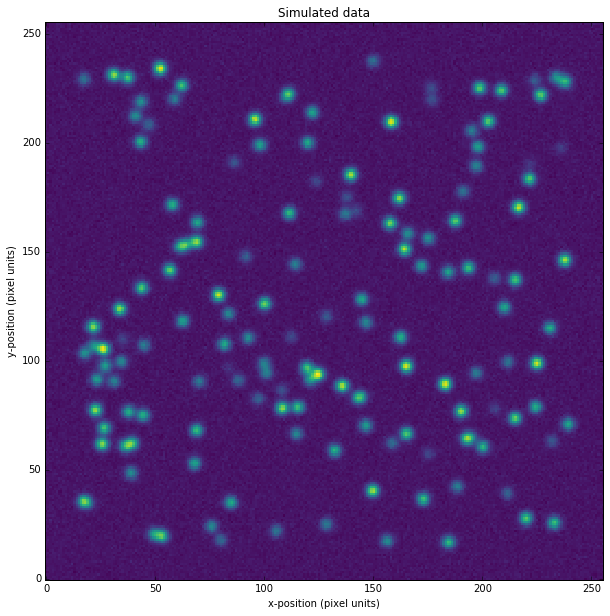

In [4]:
import numpy as np
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['image.cmap'] = 'viridis'
rcParams['image.aspect'] = 1  # to get images with square pixels
rcParams['figure.figsize'] = (20,10)
rcParams['image.interpolation'] = 'nearest'
rcParams['image.origin'] = 'lower'

plt.imshow(image)
plt.title('Simulated data')
plt.xlabel('x-position (pixel units)')
plt.ylabel('y-position (pixel units)')
plt.show()

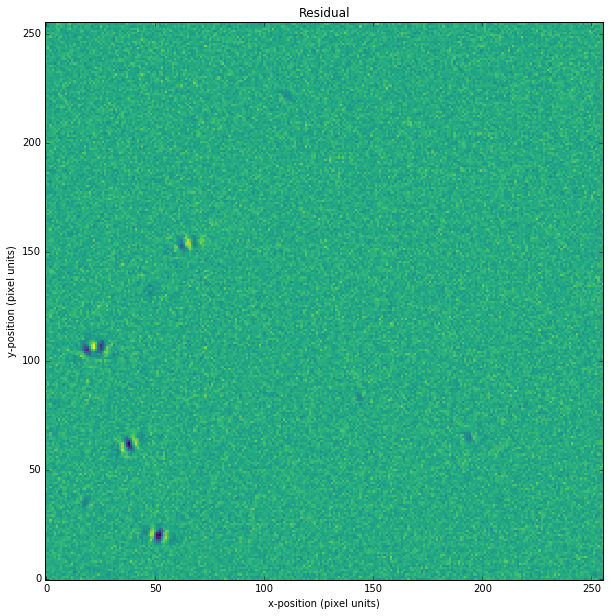

In [5]:
plt.imshow(residual_image)
plt.title('Residual')
plt.xlabel('x-position (pixel units)')
plt.ylabel('y-position (pixel units)')
plt.show()

In [6]:
result_tab.sort('id')
print(result_tab)
print(np.mean(residual_image))

 id group_id     x_fit         y_fit        flux_fit   iter_detected
--- -------- ------------- ------------- ------------- -------------
  1        1 156.260790783 17.3845228606 2333.02304936             1
  1        1 55.8822249494 18.9936831457 645.064860366             2
  2        1 47.5522100497 20.9767687677 1138.14170948             2
  2        2 184.368144648 16.8000539086  3430.1783463             1
  3        3 80.1613815737 17.7411096538 1585.39273658             1
  3        2 21.9527215261 33.6105827472 298.307633228             2
  4        4  51.920074269  20.015846639 4949.69025084             1
  4        3  79.065531002 35.1940490796 76.5471043112             2
  5        2 14.0578288211 36.6801376186 153.670977898             2
  5        5  105.47674498  21.961221042 1851.94618578             1
...      ...           ...           ...           ...           ...
131       95 176.410767615 224.943210789 994.203797579             1
132      100 198.545315858 224.831

## Photometry with fixed positions
##### Now, let's perform photometry for the case that star positions are held fixed and one is interested only in fitting the flux.

In [7]:
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True

In [8]:
positions = starlist['x_mean', 'y_mean']
positions['x_mean'].name = 'x_0'
positions['y_mean'].name = 'y_0'

In [9]:
daophot_photometry = DAOPhotPSFPhotometry(group=daogroup,
                                          bkg=mmm_bkg, psf=psf_model,
                                          fitter=LevMarLSQFitter(),
                                          fitshape=(11,11))
result_tab, residual_image = daophot_photometry(image=image, positions=positions)

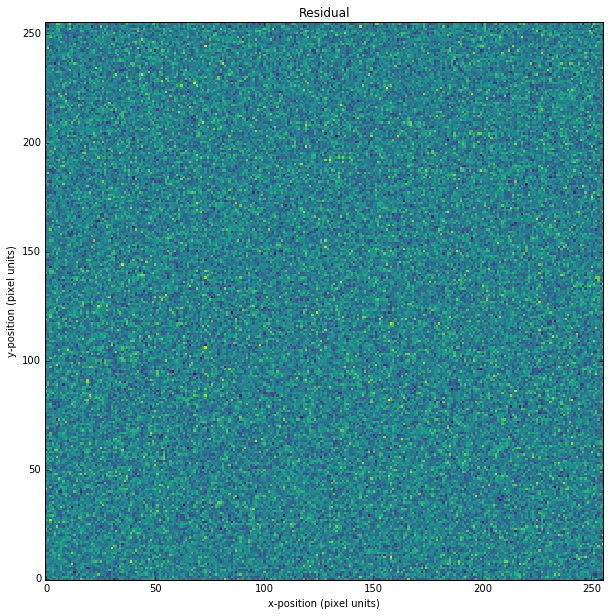

In [10]:
plt.imshow(residual_image)
plt.title('Residual')
plt.xlabel('x-position (pixel units)')
plt.ylabel('y-position (pixel units)')

In [11]:
result_tab.sort('id')
print(result_tab)

 id group_id     x_fit         y_fit        flux_fit  
--- -------- ------------- ------------- -------------
  1        1 53.1700860624 19.6719157162 3651.24214071
  2        2 190.943538112 177.545297995 1791.19379085
  3        3 80.1842021473 17.7332031642 1584.75003212
  4        4 84.6492247458 35.0001901477 3006.43930365
  5        5 165.018568238 66.5116439408 3819.81949027
  6        6 40.9518464401 212.027895588 2426.82657558
  7        7 164.931428532 97.4410952292 5007.18937119
  8        8 214.879921559 136.951025488 3646.15061908
  9        9 171.973724085 143.255119895   2671.207235
 10       10 114.633444373 66.5037927085 2265.14924342
...      ...           ...           ...           ...
140       98 230.706182437 114.940214922 3033.32143773
141       99 112.278187687 110.868042971 919.745350791
142      100 211.524876808  99.326159375 1846.34884936
143      101 95.7345176261 210.502495079 4704.90068195
144      102  224.26705825 78.8268436649 3116.98532716
145       

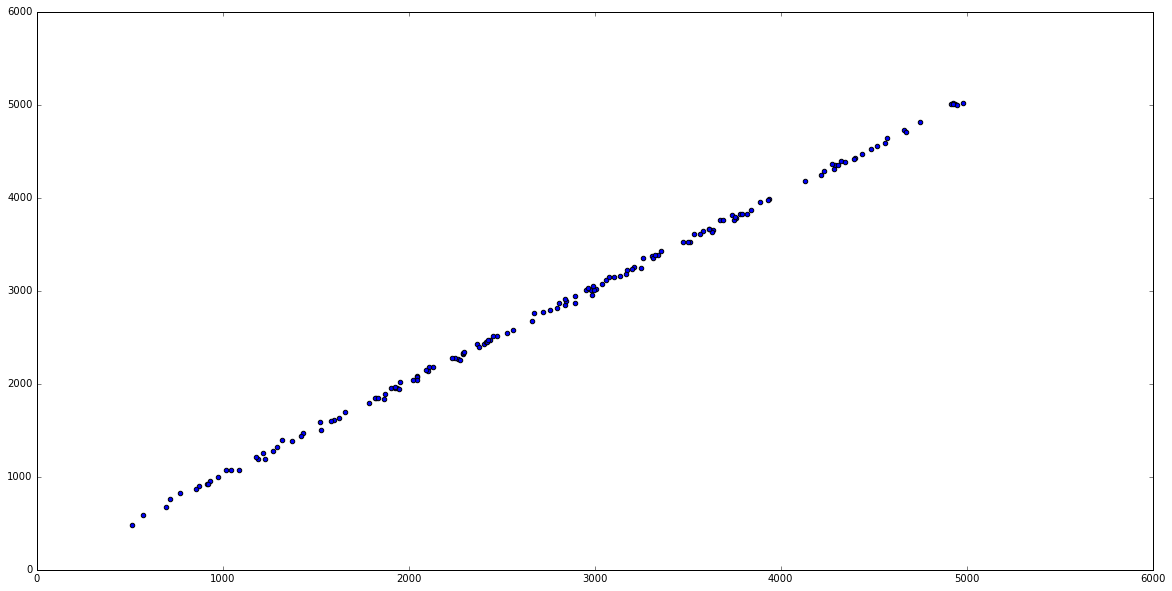

In [12]:
plt.scatter(starlist['flux'], result_tab['flux_fit'])

In [13]:
print(np.corrcoef(starlist['flux'], result_tab['flux_fit'])[0][1])
print(np.sqrt(np.mean((starlist['flux'] - result_tab['flux_fit'])**2)))
print(np.mean(residual_image))

0.999783761917
44.7227061855
0.202660770377
